# **CIS 5450 Final Project - Online Retail Customer Segmentation and Forecasting**
*Tongxun Hu, Liuyao Zhang, Tingyu Lu*

## Part 1: Introduction

E-commerce has become an essential component of modern retail, and businesses increasingly rely on data-driven strategies to understand customer behavior, optimize inventory, and improve revenue. Transaction-level datasets provide a detailed view of customer purchasing patterns, allowing researchers to analyze trends, segment customers, and build predictive models relevant to real-world retail operations.

For our final project, we examine customer purchasing behavior within the Online Retail Dataset from the UCI Machine Learning Repository. The dataset contains 541,909 transaction-level records from a UK-based online retailer between December 2010 and December 2011. Each entry represents a single invoice line and includes details such as product code, description, quantity purchased, invoice timestamp, unit price, customer identifier, and customer country.

Our objective is to use this transactional data to better understand the factors that characterize customer behavior and to explore whether we can predict meaningful outcomes such as future purchasing frequency or the likelihood of customer churn. Because the dataset captures both item-level information (e.g., quantities, prices, product types) and customer-level attributes (e.g., geographic location, purchasing recency), it supports analyses across multiple dimensions. These include temporal trends in sales, product performance, and heterogeneity across customers.

In our notebook, we conduct EDA to interpret overall sales patterns and customer dynamics, followed by predictive modeling experiments using features derived from the cleaned transaction data. At each stage, we describe the motivation behind our analyses, summarize our findings, and discuss how these results contribute to our understanding of online retail behavior.

Our goal is to provide a clear and data-driven examination of this retail environment and to evaluate the extent to which machine learning methods can help anticipate customer actions in similar settings.


## Part 2: Data Loading & Preprocessing

In this section, we describe the steps taken to load the Online Retail dataset and prepare it for analysis. Because our downstream tasks involve customer-level feature engineering and prediction, it is essential to ensure that the data is consistent, well-structured, and free from irregularities that could bias results.


### 2.1 Loading the Dataset

We use the `ucimlrepo` package to access the Online Retail dataset (UCI ID: 352). The original dataset contains 541,909 transaction records and eight columns. For reproducibility, we load the dataset directly from the repository rather than relying on local copies.


In [3]:
# Imports + Installs
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

online_retail = fetch_ucirepo(id=352)
df = online_retail.data.original  # full dataset as provided
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


The dataset consists of the following fields:

* **InvoiceNo**: transaction identifier (invoices starting with 'C' indicate cancellations)
* **StockCode**: unique product code
* **Description**: product name
* **Quantity**: number of units purchased
* **InvoiceDate**: timestamp of the transaction
* **UnitPrice**: price per unit (in sterling)
* **CustomerID**: unique customer identifier
* **Country**: customer’s country

After loading, we perform a basic inspection to confirm dimensions and variable types:

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
df.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [12]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 2.2 Handling Missing Customer Identifiers

135,080records (~25%) do not contain a CustomerID. Since many of our downstream analyses require customer-level aggregation (e.g., calculating recency, frequency, and monetary metrics), we remove rows lacking a valid identifier.

In [13]:
df = df.dropna(subset=["CustomerID"])


### 2.3 Handling Missing Descriptions


The Description field contains 1,454 missing values. Because product names are not required for our numerical analyses (revenue calculations, customer metrics, time series analysis), and because product-level modeling is not part of our objectives, we take the simplest approach and drop rows with missing descriptions.

In [15]:
df = df.dropna(subset=["Description"])

### 2.4 Removing Cancelled Transactions

Invoice numbers beginning with 'C' represent cancellations or returns. These transactions often have negative quantities and do not reflect completed purchases. To avoid distorting revenue and customer behavior, we remove them:

In [17]:
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

### 2.5 Filtering Invalid Quantity and Unit Price Values

The raw data includes several records with:
* Negative or zero quantities
* Zero or negative unit prices

These values are typically associated with corrections or invalid entries. We retain only transactions with positive quantities and prices:

In [18]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]


### 2.6 Enforcing Correct Data Types

To support time-based resampling and grouping operations, we convert relevant fields to appropriate data types. This ensures clean temporal calculations and avoids treating customer identifiers as numeric quantities.

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype(str)

### 2.7 Creating Derived Variables

To facilitate exploratory analysis and later modeling, we create several additional fields. These engineered fields help simplify downstream computations involving trends, seasonality, and customer summaries.
* TotalPrice: the monetary value of each line item

In [22]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

* InvoiceMonth: year–month period for monthly aggregation

In [23]:
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

* InvoiceDateOnly: date-only for daily analysis

In [25]:
df["InvoiceDateOnly"] = df["InvoiceDate"].dt.date

After all preprocessing steps, our cleaned dataset includes:
* Approximately 397,884 valid transactions
* No missing customer identifiers or product descriptions
* No cancellations or negative-value records
* Clean and uniform date fields
* Additional derived variables enabling temporal and monetary analysis


In [27]:
df.shape

(397884, 11)

## 3. Exploratory Data Analysis (EDA)

In this section, we explore the cleaned Online Retail dataset to understand overall sales activity, customer behavior, product patterns, and temporal trends. Because the dataset contains over 397,000 valid transactions across a full year, our EDA focuses not only on summary statistics but also on structural patterns that may influence modeling choices.

Throughout this section, we aim to connect each observation to a potential modeling implication, such as feature design or considerations for train–test splits.

### 3.1 Overview of Transaction-Level Metrics

We begin by examining descriptive statistics for the three key numerical fields in the dataset: `Quantity`, `UnitPrice`, and `TotalPrice`. These metrics help characterize overall purchasing patterns and identify skew or outliers that may influence modeling.


In [28]:
df[["Quantity", "UnitPrice", "TotalPrice"]].describe()

,Quantity,UnitPrice,TotalPrice
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,22.397000
std,179.331775,22.097877,309.071041
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


#### Key observations

* **Quantity**

  * The mean quantity per line item is **13**, but the median is only **6**, indicating substantial right skew.
  * The maximum quantity (**80,995 units**) confirms the presence of wholesale-level bulk purchases.
  * The extremely large standard deviation (**179**) further reflects this heavy-tailed behavior.

* **UnitPrice**

  * The median price is only **£1.95**, and the majority of products fall between **£1–£4**.
  * However, UnitPrice ranges up to **£8,142.75**, suggesting a small set of very high-value items.
  * The high standard deviation (**22.10**) again indicates significant variability.

* **TotalPrice**

  * Despite a median transaction value of **£11.80**, the maximum TotalPrice reaches **£168,469.60**.
  * This gap demonstrates how large bulk purchases dominate revenue, even though typical transactions are relatively small.

#### Interpretation

All three key variables contain extreme outliers, which is typical in transactional retail datasets. This has several implications for later modeling:

* Features may require **log transformation** or **robust scaling** to avoid domination by extreme values.
* Median-based statistics may be more informative than means for customer-level features.
* Models must be evaluated carefully to avoid being dominated by wholesale customers.

### 3.2 Temporal Patterns in Sales Activity

Given that the dataset covers slightly more than a full year, temporal analysis is essential to understanding seasonality and sales dynamics.

#### 3.2.1 Daily Transaction Volume

<AxesSubplot:title={'center':'Daily Transaction Counts'}, xlabel='InvoiceDateOnly'>

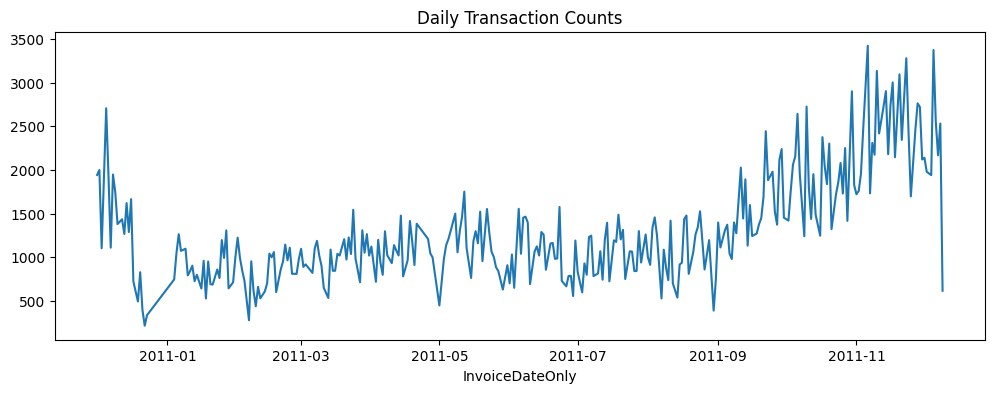

In [29]:
daily_counts = df.groupby("InvoiceDateOnly").size()
daily_counts.plot(figsize=(12,4), title="Daily Transaction Counts")


- Daily sales fluctuate significantly, ranging from fewer than **300** transactions to nearly **3,500** at peak.
- Activity in early 2011 is lower and more stable, with many days between **500–1,200** transactions.
- Beginning around **August 2011**, transaction counts steadily rise, with noticeably more volatility.
- The highest activity occurs in **November 2011**, consistent with early holiday shopping behavior.
- The sharp decline in December is not due to seasonality—it results from the dataset ending on December 9.

Key Takeaways:
- Customer behavior changes significantly across the year.
- Time-based features such as *month*, *day of week*, and *season* may improve predictive modeling.
- For tasks involving forecasting, a **chronological train–test split** is necessary to avoid leakage due to the strong upward trend in the final months.



#### 3.2.2 Monthly Revenue Trends

To smooth out daily variability and understand broader patterns, we aggregate revenue by month:


<AxesSubplot:title={'center':'Monthly Revenue'}, xlabel='InvoiceMonth'>

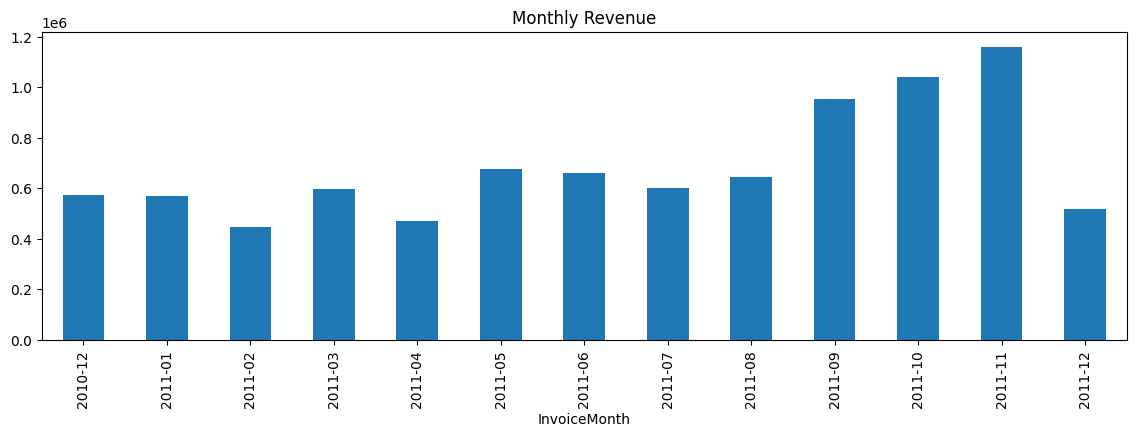

In [31]:
monthly_revenue = df.groupby("InvoiceMonth")["TotalPrice"].sum()
monthly_revenue.plot(kind="bar", figsize=(14,4), title="Monthly Revenue")

In [32]:
df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

**Interpretation:**

- Revenue in late 2010 and early 2011 remains relatively stable around **£450k–£600k** per month.
- There is a notable dip in **February 2011**, followed by recovery in March and May.
- Starting in **September 2011**, revenue accelerates markedly, rising from around **£650k** to over **£1 million** by October.
- The highest monthly revenue occurs in **November 2011**, approaching **£1.2 million**.
- December’s revenue appears low due to incomplete data (only nine days recorded).

Key Takeaways:

- The retailer experiences strong seasonality, with clear holiday-driven spikes.
- Predictive models may benefit from including:
  - Month-of-year indicators  
  - Rolling purchase windows  
  - Customer recency relative to calendar cycles  
- When modeling churn or future purchases, we should consider that customer behavior in high-revenue months may differ from other periods.


### 3.3 Product-Level Analysis

Product-level patterns provide insight into what customers buy and how different product types contribute to overall revenue.

#### 3.3.1 Most Frequently Purchased Products

In [33]:
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
top_products


Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

Interpretation
Several notable patterns emerge:
- The top-selling item ("PAPER CRAFT, LITTLE BIRDIE") exceeds 80,000 units, far more than typical retail quantities, strongly suggesting bulk wholesale purchasing.
- Many top items are low-cost, small household or craft items, ideal for reselling or bundling.
- Several products appear in gift, novelty, or decorative categories, consistent with the retailer’s stated business model of selling “all-occasion gifts.”
- Some products (e.g., “PACK OF 72 RETROSPOT CAKE CASES”) are sold in large pre-packed quantities, which further increases total purchased units.

Key Takeaways:
* Product-level skew confirms that the dataset contains **two customer archetypes**:
  **(1) individual consumers** and **(2) wholesale/resale customers**.
* This insight is important for modeling because wholesale customers:

  * buy in much larger quantities
  * have very different purchasing patterns
  * distort mean-based statistics
* Distinguishing these two groups (implicitly or explicitly) may significantly improve:

  * customer segmentation
  * churn prediction
  * future purchase forecasting




#### 3.3.2 Highest Revenue Products

In [34]:
top_revenue_products = df.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)
top_revenue_products


Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64

### Interpretation

This revenue ranking highlights several interesting patterns:

* **“PAPER CRAFT, LITTLE BIRDIE”** is the top product **in both quantity and revenue**, reinforcing its role as a major wholesale or repeat-purchase item.
* **“REGENCY CAKESTAND 3 TIER”** generates extremely high revenue despite not appearing in the top-quantity list.
  This indicates a higher unit price and lower purchase frequency — typical of premium gift/home goods.
* **“POSTAGE”** ranking #6 suggests many orders required shipping fees, which contribute substantially to total revenue.
* Items like **“Manual”** and **“Party Bunting”** appear here but not in the quantity list, again showing that higher-priced or specialty products can have a disproportionate revenue impact.
* Several products appear on *both* top lists (revenue + quantity), including:
  **White Hanging Heart T-Light Holder**,
  **Jumbo Bag Red Retrospot**,
  **Medium Ceramic Top Storage Jar**,
  **Assorted Colour Bird Ornament**,
  **Rabbit Night Light**.

These are likely core catalog items with consistent year-round demand.

Key Takeaways:

* Comparing quantity vs. revenue rankings helps distinguish **high-frequency low-price items** from **low-frequency high-value items**.
* This distinction affects:

  * feature engineering (e.g., customer value metrics)
  * forecasting (some products have predictable demand, others do not)
  * segmentation (wholesalers vs. normal consumers)
* Revenue-based rankings provide better insight into the **economic drivers** of the business.

### 3.4 Customer-Level Behavior

The Online Retail dataset shows strong heterogeneity in customer behavior. We analyze spending, frequency, and recency patterns that are relevant for predicting churn or future purchases.

#### 3.4.1 Number of Unique Customers

In [36]:
df["CustomerID"].nunique()

4338

#### 3.4.2 Distribution of Customer Spending

In [37]:
customer_spend = df.groupby("CustomerID")["TotalPrice"].sum()
customer_spend.describe()


count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalPrice, dtype: float64

**Interpretation**

- TotalPrice increases roughly linearly with quantity for low-priced, high-volume items.
- A small number of transactions exhibit extremely high total values (≥ £75,000 and one above £160,000).  
  These correspond to items like **“PAPER CRAFT, LITTLE BIRDIE”**, which dominate both quantity and revenue.
- For high-priced products, even small quantities generate substantial revenue.

**Implications**

- A few transactions contribute disproportionately to total revenue.
- Mean-based metrics will be dominated by extreme outliers unless mitigated.
- Customer-level models should consider **robust aggregations**, such as medians or log-transformed features.


#### 3.4.3 Purchase Frequency

In [39]:
customer_frequency = df.groupby("CustomerID")["InvoiceNo"].nunique()
customer_frequency.describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: InvoiceNo, dtype: float64

**Interpretation**

* Half of all customers made **two or fewer purchases** during the year.
* High-frequency customers (≥ 20 purchases) are rare but economically important.
* The maximum customer placed **209 distinct orders**, further confirming wholesale activity.

**Implications**

* Churn prediction is a realistic problem: most customers do not return frequently.
* Customers exhibit diverse behaviors:

  * Occasional one-time shoppers
  * Periodic return customers
  * Very frequent high-volume wholesalers

RFM (Recency–Frequency–Monetary) features are likely valuable for modeling.


### 3.5 Country-Level Trends

#### 3.5.1 Geographic Distribution of Orders

In [41]:
df["Country"].value_counts().head(10)

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

**Interpretation**

- The dataset is heavily dominated by the **United Kingdom**, which accounts for nearly 90% of all transactions.
- **Germany, France, and Ireland (EIRE)** are the next-largest customer groups, though their activity is still much smaller compared to the UK.
- Many smaller countries appear only **sporadically**, contributing relatively few transactions.

**Implications**

- Country is still a useful categorical feature, but:
  - One-hot encoding would produce many **sparse, low-frequency categories**.
  - Grouping rare countries into an **"Other"** category may improve model stability.
- The UK-heavy distribution suggests that most observed patterns primarily reflect **UK consumer and wholesale behavior**, which should be considered when interpreting model outputs.


### 3.6 Relationships Between Key Variables

#### 3.6.1 Quantity vs. Unit Price

<AxesSubplot:xlabel='UnitPrice', ylabel='Quantity'>

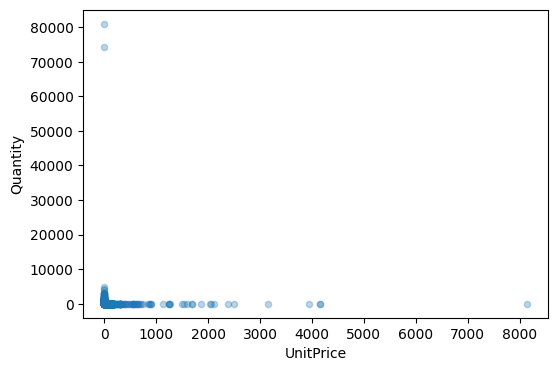

In [42]:
df.plot.scatter(x="UnitPrice", y="Quantity", alpha=0.3, figsize=(6,4))

### Interpretation

- The vast majority of purchases occur at **very low unit prices**, generally below £10. This aligns with the retailer’s focus on inexpensive gift and craft items.
- As **unit price increases, purchased quantities drop sharply**:
  - Items priced above £50 are rarely bought in more than 1–2 units.
  - Items priced above £500 are almost always purchased individually.
- A few extreme points in the upper-left corner (quantities of **70,000–80,000 units**) represent **bulk wholesale purchases** of low-priced items.
- The plot clearly shows two dominant purchasing patterns:
  1. **Low-price, high-quantity wholesale behavior**  
  2. **Higher-price, low-quantity retail behavior**

### Implications

- Quantity and UnitPrice are **highly skewed** and contain powerful signals about the type of customer (retail vs. wholesale).
- For modeling:
  - Log-transformation or robust scaling may be necessary to prevent extreme values from dominating the model.
  - Features capturing **price tier** or **bulk-purchase patterns** may improve predictive accuracy.
- This distribution reinforces that customer behavior is **heterogeneous**, and segmentation may be beneficial before modeling.


#### 3.6.2 Quantity vs. TotalPrice

<AxesSubplot:xlabel='Quantity', ylabel='TotalPrice'>

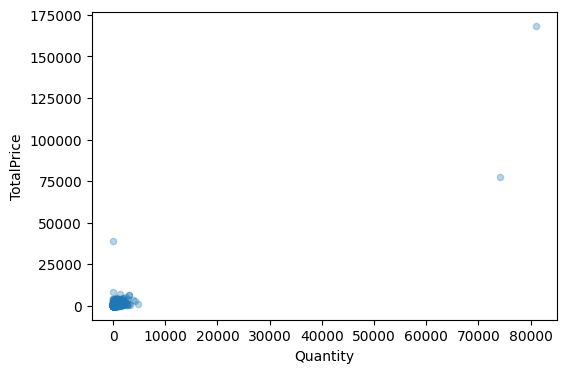

In [44]:
df.plot.scatter(x="Quantity", y="TotalPrice", alpha=0.3, figsize=(6,4))

### Interpretation

- TotalPrice increases with Quantity, but the relationship is **highly uneven** because low-price items and high-price items behave differently.
- Most transactions cluster tightly near the origin, with quantities below **2,000** and revenues below **£5,000**, reflecting typical small-scale consumer purchases.
- A few extreme outliers dominate the scale:
  - One transaction with ~**80,000 units** generates nearly **£170,000** in revenue.
  - Another transaction with ~**75,000 units** produces over **£75,000**.
  - These correspond to highly inexpensive items purchased in bulk, likely by **wholesale customers**.
- For higher-priced products, even small quantities yield substantial revenue.  
  For example, a transaction with only a few units produces over **£40,000** in revenue, highlighting strong variability in price ranges.

### Implications

- The distribution of TotalPrice is **extremely right-skewed**, suggesting the need for:
  - log-transformation,
  - outlier handling, or  
  - robust statistical methods.
- Wholesale customers and consumer customers form **distinct behavioral modes**:
  - **Bulk, low-price purchases**  
  - **Small-quantity, high-price purchases**
- Because a small number of transactions account for a very large share of total revenue, models predicting customer value must avoid being overly influenced by these rare but extreme observations.
